# Classification to identify tasks

**Created by: _Matthieu Gilson & Gorka Zamora-López_**

The Human Brain Project SGA0 - SGA2 (SP4); SGA3 (WP1)  /  Pompeu Fabra University, Barcelona.

<img src="Logo_HBP_small.png" style="float:left; width:254px; heigth:50px " alt="HBP logo" />
<img src="Logo_UPF_small.png" style="float:right; width:149px; height:50px"  alt="UPF logo" />


<br/>
<br/>
<br/>
<br/>

-----------------
The purpose of this notebook is to showcase, test and validate the integration of effective connectivity tools in EBRAINS and for use in broader workflows. This notebook should:

- Retrieve and load the results of whole-brain EC, estimated previously along the workflow.
- Use machine learning tools that are integrated in EBRAINS (Scikit-learn) to perform classification of the data.
- Save / export the results and use EBRAINS visualization tools to create fancier outputs, e.g. a brain visualiser.

-----------------

Here, we will load whole-brain effective previously estimated (see for example the notebook '1_Mou-EC_estimation.ipynb'. The goal is to compare the connectivity measures (in particular, effective versus functional connectivity) in identifying tasks performed by subjects in the scanner. 


#### References and documentation

1. M Gilson, G. Deco, K. Friston et al. (2018) "Effective connectivity inferred from fMRI transition dynamics during movie viewing points to a balanced reconfiguration of cortical interactions." NeuroImage 180, 534-546.
DOI: https://doi.org/10.1016/j.neuroimage.2017.09.061
2. Gilson M, Zamora-López G, Pallarés V, et al. (2020) "Model-based whole-brain effective connectivity to study distributed cognition in health and disease", Network Neurosci. 4(2) 338-373.
DOI: https://doi.org/10.1162/netn_a_00117


#### Software
This Notebook employs Scikit-learn for the classification via machine-learning methods
Web: https://scikit-learn.org/stable/
GitHub: https://github.com/scikit-learn/scikit-learn


#### Data
We employ structural connectivity and resting-state fMRI from published data. It consists of recordings for a cohort of 22 healthy participants udergoing five fMRI sessions each: two sessions in resting-state (R1, R2) and three sessions while watching three distinct segments of a movie (M1, M2, M3).

1. J. Hlinka, M. Palus, M. Vejmelka, et al. (2011) "Functional connectivity in resting-state fMRI: is linear correlation sufficient?" NeuroImage 54, 2218–2225.
DOI: https://doi.org/10.1016/j.neuroimage.2010.08.042
2. D. Mantini, U. Hasson, V. Betti, et al. (2012) "Interspecies activity correlations reveal functional correspondence between monkey and human brain areas." Nat. Methods 9, 277–282.
DOI: https://doi.org/10.1038/nmeth.1868


_**TO-DO**: Reproduce this notebook using a dataset accessible in EBRAINS. This "movie" dataset is not part of the EBRAINS catalog. At least not yet. See file "0\_README.md" for suggestions._

<br>



---------
### TO-DO list towards full EBRAINS integration 
Missing technical points, for full integration of the workflows in this notebook.

- Input data is the result of whole-brain EC estimation, which can simply be stored in Drive and loaded here. But… any fancier interface shall be built?
- Interface to visualization services. Visualise results in a "standard brain map".

<br>

----------
### Import the dependencies

In [1]:
# Import standard library modules
import os
# Import 3rd party packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stt

import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.discriminant_analysis as skda
import sklearn.preprocessing as skppc
import sklearn.pipeline as skppl
import sklearn.metrics as skm


### Load and prepare the data

The data required in this notebook is the output of the MOU-EC estimation method previously calculated and saved in, for example, a notebook like '1_MOU-EC_Estimation.ipynb'

So far, we will load datafiles stored in the local Drive of this collab: _'.../Effective Connectivity estimation/Datasets/Movie/'_ . The required data files are:

- 'ECdata_Movie.npz': zipped file containing various results from the MOU-EC estimation.
- 'BOLD_Movie_filtered.npy': BOLD-fMRI (all sessions and subjects) needed to compute the 0-lag covariances

We load the data and calculate the features: 'EC' stands for effective connectivity (previously in the workflow, see for example the *1_MOU-EC_Estimation.ipynb* notebook), 'FC' stands for the BOLD correlations, 'FC + mask' for the BOLD correlations only concerning the ROI connections that exist according to the structural data (diffusion tensor imaging), 'PC' for the partial correlations.



In [2]:
%pwd

'/mnt/user/drive/Shared with groups/Effective Connectivity estimation/Jupyter_Notebooks'

In [3]:
## Load the data needed for the fMRI data from the Drive
datapath = '/mnt/user/drive/Shared with groups/Effective Connectivity estimation/Datasets/Movie/'

# 1) Load data previously generated, e.g., in a notebook like '1_MOU-EC_Estimation.ipynb'
ec_data = np.load( datapath + 'ECdata_Movie.npz' )

# Effective connectivity matrices
EC = ec_data['EC_mod']
# Mask of existing connections in SC (structural connectivity)
mask_EC = ec_data['mask_EC']
# Extract the number of subjects, sessions and nodes
n_sub, n_run, N, N = np.shape(EC)


# 2) Load the BOLD signals and calculate the 0-lag covariance matrices
ts_emp = np.load( datapath + 'BOLD_movie_filtered.npy' )

FC0 = np.zeros([n_sub,n_run,N,N], np.float)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        FC0[i_sub,i_run] = np.cov(ts_emp[i_sub,i_run])


# Generate a triangular mask to retain half of the matrix elemenets 
mask_tri = np.tri(N,N, k=-1, dtype=np.bool)

# Print some feedback
print( 'Number of subjects:', n_sub )
print( 'Number of sessions:', n_run )
print( 'Number of ROIs:', N )


Number of subjects: 22
Number of sessions: 5
Number of ROIs: 66


In [4]:
# Toggle to True to create directory and store results there
save_outputs = False
if save_outputs:
    import os
    res_dir = datapath + 'classif/'
    if not os.path.exists(res_dir):
        os.mkdir(res_dir)

<br>

### Perform the task-based classification

In [5]:
# Calculate features based on EC (effective connectivity)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        # apply z-scoring to EC
        EC[i_sub,i_run,mask_EC] = stt.zscore(EC[i_sub,i_run,mask_EC])

# Calculate the features based on FC (functional connectivity)
corr = np.copy(FC0)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        corr[i_sub,i_run,:,:] /= np.sqrt( np.outer(corr[i_sub,i_run,:,:].diagonal(), 
                                                   corr[i_sub,i_run,:,:].diagonal()) )

# Calculate the features based on PC (partial correlations)
PC = np.copy(FC0)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        PC[i_sub,i_run,:,:] = -np.linalg.pinv(PC[i_sub,i_run,:,:])
        PC[i_sub,i_run,:,:] /= np.sqrt( np.outer(PC[i_sub,i_run,:,:].diagonal(), 
                                                 PC[i_sub,i_run,:,:].diagonal()) )

print( 'Done' )

Done


The following code performs the task classification by splitting the fMRI sessions into a train set and a test set (`n_rep` times). Here the 22 subjects are split in 80% for training and 20% for testing. We compare 3 classifiers:

- MLR is the multinomial logistic regression;
- 1NN is the 1-nearest-neighbor;
- LDA performs the linear discriminant analysis.

See the [scikit-learn](https://scikit-learn.org/stable/) webpage for details.
<br>

In [7]:
# WARNING: Running this cell will take a few minutes
# Labels of sessions for classification
n_conn = 4

# distinct labels for movie runs
task4_labels = np.repeat( np.array([0,0,1,2,3], 
                            dtype=np.int).reshape([1,-1]), 
                            n_sub, axis=0 )
# rest versus movie, same labels for movie runs
RM_labels = np.repeat( np.array([0,0,1,1,1], 
                            dtype=np.int).reshape([1,-1]), 
                            n_sub, axis=0 ) 

# number of repetitions and storage of results
n_rep = 40
# first index: task4_labels/RM_labels; last index: MRL/1NN/LDA
perf = np.zeros([2,n_rep,n_conn,3])

# Loop over classification type
for i_classif in range(2):

    if i_classif==0:
        # discriminate rest and 3 movie sessions individually
        lab_tmp = task4_labels
        print( 'Running classification: tasks ...' )
    else:
        # discriminate rest vs movie
        lab_tmp = RM_labels
        print( '\nRunning classification: rest vs. movie ...' )

    # Repeat classification
    for i_rep in range(n_rep):
        print( '  Repetition %d' %i_rep )
        
        # Split run indices in train and test sets 
        # (choose some subjects for train and rest for test)
        train_ind = np.ones([n_sub,n_run], dtype=bool)
        while train_ind[:,0].sum() >= 0.8 * n_sub:
            train_ind[np.random.randint(n_sub),:] = False
        test_ind = np.logical_not(train_ind)        

        # Loop over connectivity measures
        for i_conn in range(n_conn):

            if i_conn==0:
                # vectorized EC matrices (only retaining existing connections)
                vect_features = EC[:,:,mask_EC]
            elif i_conn==1:
                # vectorized FC matrices (only retaining low triangle)
                vect_features = corr[:,:,mask_tri]
            elif i_conn==2:
                # vectorized FC matrices (only retaining SC existing connections)
                vect_features = corr[:,:,mask_EC]
            else:
                # vectorized PCmatrices (only retaining low triangle)
                vect_features = PC[:,:,mask_tri]

            # dimension of vectorized EC
            dim_feature = vect_features.shape[2]

            # Number of components for LDA
            if i_classif==0:
                n_comp_LDA = 3
            else:
                n_comp_LDA = 1

            # Classifier and learning parameters
            c_MLR = skppl.make_pipeline( skppc.StandardScaler(), 
                                        skllm.LogisticRegression(C=0.1, 
                                                                 penalty='l2', 
                                                                 multi_class='multinomial', 
                                                                 solver='lbfgs', 
                                                                 max_iter=500) )
            c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, 
                                               algorithm='brute', 
                                               metric='correlation')
            c_LDA = skda.LinearDiscriminantAnalysis(n_components=n_comp_LDA, 
                                                    solver='eigen', 
                                                    shrinkage='auto')
            
            # Train and test classifiers with subject labels
            c_MLR.fit(vect_features[train_ind,:], lab_tmp[train_ind])
            perf[i_classif, i_rep,i_conn,0] = \
                c_MLR.score( vect_features[test_ind,:], lab_tmp[test_ind] )
        
            c_1NN.fit(vect_features[train_ind,:], lab_tmp[train_ind])
            perf[i_classif, i_rep,i_conn,1] = \
                c_1NN.score(vect_features[test_ind,:], lab_tmp[test_ind])
        
            c_LDA.fit(vect_features[train_ind,:], lab_tmp[train_ind])
            perf[i_classif, i_rep,i_conn,2] = \
                c_LDA.score(vect_features[test_ind,:], lab_tmp[test_ind])


print( '\nFinished.')

Running classification: tasks ...
  Repetition 0
  Repetition 1
  Repetition 2
  Repetition 3
  Repetition 4
  Repetition 5
  Repetition 6
  Repetition 7
  Repetition 8
  Repetition 9
  Repetition 10
  Repetition 11
  Repetition 12
  Repetition 13
  Repetition 14
  Repetition 15
  Repetition 16
  Repetition 17
  Repetition 18
  Repetition 19
  Repetition 20
  Repetition 21
  Repetition 22
  Repetition 23
  Repetition 24
  Repetition 25
  Repetition 26
  Repetition 27
  Repetition 28
  Repetition 29
  Repetition 30
  Repetition 31
  Repetition 32
  Repetition 33
  Repetition 34
  Repetition 35
  Repetition 36
  Repetition 37
  Repetition 38
  Repetition 39

Running classification: rest vs. movie ...
  Repetition 0
  Repetition 1
  Repetition 2
  Repetition 3
  Repetition 4
  Repetition 5
  Repetition 6
  Repetition 7
  Repetition 8
  Repetition 9
  Repetition 10
  Repetition 11
  Repetition 12
  Repetition 13
  Repetition 14
  Repetition 15
  Repetition 16
  Repetition 17
  Repetition 1

In [8]:
# Save the results and the metadata into a file for later use
res_dir = datapath + 'classif/'
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

np.save( res_dir + 'perf_tasks.npy', perf )



Saving the results into files ... 


The performance is interpreted by comparing the classification accuracy with the chance level (the dashed line), in relation with the gap towards 100% correct. Here we can calculate the chance level straight from the session properties.

<br>

#### Plot the task-classification results

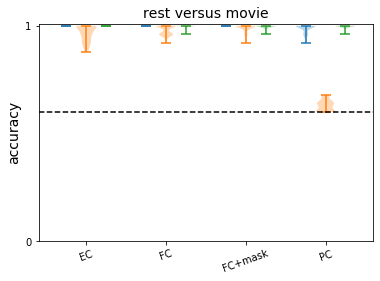

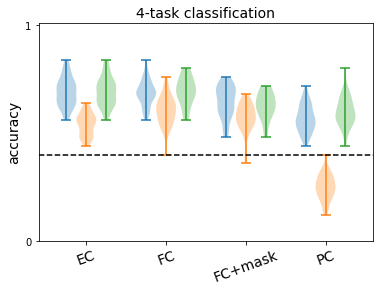

In [9]:
n_conn = 4

# Plot rest versus movie
# chance level: predicting always movie gives 60% (as compared to predicting rest, 40%)
chance_level = 3. / n_run 

plt.figure()
plt.violinplot(perf[1,:,:,0], positions=np.arange(n_conn)-0.25, widths=[0.25]*n_conn)
plt.violinplot(perf[1,:,:,1], positions=np.arange(n_conn), widths=[0.25]*n_conn)
plt.violinplot(perf[1,:,:,2], positions=np.arange(n_conn)+0.25, widths=[0.25]*n_conn)
plt.plot([-1,n_conn], [chance_level]*2, '--k')
plt.axis(xmin=-0.6, xmax=n_conn-0.4, ymin=0, ymax=1.01)
plt.xticks(range(n_conn), ['EC','FC','FC+mask','PC'], rotation=20)
plt.yticks([0,1])
plt.ylabel('accuracy', fontsize=14)
plt.title('rest versus movie', fontsize=14)

#plt.savefig(res_dir + 'perf_RM.png', format='png')

# Plot 4 classes (rest, movie1, movie2, movie3)
# Chance level: predicting always rest gives 40% (as compared to predicting 
# a movie session, 20%)
chance_level = 2. / n_run 

plt.figure()
plt.violinplot(perf[0,:,:,0], positions=np.arange(n_conn)-0.25, widths=[0.25]*n_conn)
plt.violinplot(perf[0,:,:,1], positions=np.arange(n_conn), widths=[0.25]*n_conn)
plt.violinplot(perf[0,:,:,2], positions=np.arange(n_conn)+0.25, widths=[0.25]*n_conn)
plt.plot([-1,n_conn], [chance_level]*2, '--k')
plt.axis(xmin=-0.6,xmax=n_conn-0.4,ymin=0,ymax=1.01)
plt.xticks(range(n_conn), ['EC','FC','FC+mask','PC'], rotation=20, fontsize=14)
plt.yticks([0,1])
plt.ylabel('accuracy', fontsize=14)
plt.title('4-task classification', fontsize=14)

#plt.savefig(res_dir + 'perf_4tasks.png', format='png')
    
plt.show()

<br>

### Confusion matrices ...

... are useful to understand the errors performed by the train classifier on the test set. Each row represents the classification of a test sample, with the diagonal element corresponding to the correct classification and off-diagonal elements to errors. Here we separate the 5 sessions to show that the two rest sessions are not separable by the MRL.

In [10]:
# Use vectorized EC as features
vect_features = EC[:,:,mask_EC]
                   
# Individual labels for each session for classification (separating the 2 rest sessions)
# Distinct labels for each run/session
run5_labels = np.repeat( np.array([0,1,2,3,4],dtype=np.int).reshape([1,-1]), 
                         n_sub, 
                         axis=0 ) 

# Confusion matrices (1 dimension per condition)
conf_mat_MLR = np.zeros([n_rep,n_run,n_run])
conf_mat_1NN = np.zeros([n_rep,n_run,n_run])

# Perform classification
for i_rep in range(n_rep):

    # Split run indices in train and test sets 
    # (choose some subjects for train and rest for test)
    train_ind = np.ones([n_sub,n_run],dtype=bool)
    while train_ind[:,0].sum() >= 0.8*n_sub:
        train_ind[np.random.randint(n_sub),:] = False
    test_ind = np.logical_not(train_ind)
    
    # Train and test classifiers with subject labels
    c_MLR.fit( vect_features[train_ind,:], run5_labels[train_ind] )
    conf_mat_MLR[i_rep,:,:] = \
            skm.confusion_matrix( y_true=run5_labels[test_ind], 
                                  y_pred=c_MLR.predict(vect_features[test_ind,:]) )

    c_1NN.fit( vect_features[train_ind,:], run5_labels[train_ind] )
    conf_mat_1NN[i_rep,:,:] = \
            skm.confusion_matrix( y_true=run5_labels[test_ind], 
                                  y_pred=c_1NN.predict(vect_features[test_ind,:]) )

#### Plot the confusion matrices

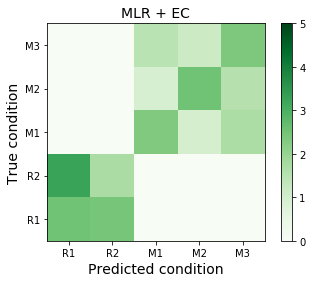

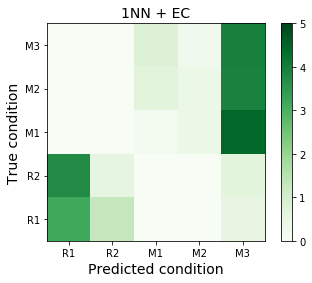

In [11]:
plt.figure()
plt.imshow(conf_mat_MLR.mean(0), origin='bottom', cmap='Greens', vmin=0, vmax=5)
plt.xticks(range(n_run), ['R1','R2','M1','M2','M3'])
plt.yticks(range(n_run), ['R1','R2','M1','M2','M3'])
plt.colorbar(ticks=range(6))
plt.xlabel('Predicted condition', fontsize=14)
plt.ylabel('True condition', fontsize=14)
plt.title('MLR + EC', fontsize=14)

plt.figure()
plt.imshow(conf_mat_1NN.mean(0), origin='bottom', cmap='Greens', vmin=0, vmax=5)
plt.xticks(range(n_run), ['R1','R2','M1','M2','M3'])
plt.yticks(range(n_run), ['R1','R2','M1','M2','M3'])
plt.colorbar(ticks=range(6))
plt.xlabel('Predicted condition', fontsize=14)
plt.ylabel('True condition', fontsize=14)
plt.title('1NN + EC', fontsize=14)
    
plt.show()